In [1]:
import localgraphclustering as lgc

import time
import numpy as np

# Import the graph_tool module for visualization.
from graph_tool.all import * 

# Import matplotlib 
import matplotlib.pyplot as plt

# Just a useful function.
def diff(a, b):
        b = set(b)
        return np.asarray([aa for aa in a if aa not in b], dtype = 'int64')
    
import pickle
import csv

# The following code is for random generation of colors.
# See here: https://stackoverflow.com/questions/14720331/how-to-generate-random-colors-in-matplotlib
def rand_cmap(nlabels, type='bright', first_color_black=True, last_color_black=False, verbose=True):
    """
    Creates a random colormap to be used together with matplotlib. Useful for segmentation tasks
    :param nlabels: Number of labels (size of colormap)
    :param type: 'bright' for strong colors, 'soft' for pastel colors
    :param first_color_black: Option to use first color as black, True or False
    :param last_color_black: Option to use last color as black, True or False
    :param verbose: Prints the number of labels and shows the colormap. True or False
    :return: colormap for matplotlib
    """
    from matplotlib.colors import LinearSegmentedColormap
    import colorsys
    import numpy as np

    np.random.seed(seed=10)
    np.random.RandomState(seed=10)

    if type not in ('bright', 'soft'):
        print ('Please choose "bright" or "soft" for type')
        return

    if verbose:
        print('Number of labels: ' + str(nlabels))

    # Generate color map for bright colors, based on hsv
    if type == 'bright':
        randHSVcolors = [(np.random.uniform(low=0.0, high=1),
                          np.random.uniform(low=0.2, high=1),
                          np.random.uniform(low=0.9, high=1)) for i in range(nlabels)]

        # Convert HSV list to RGB
        randRGBcolors = []
        for HSVcolor in randHSVcolors:
            randRGBcolors.append(colorsys.hsv_to_rgb(HSVcolor[0], HSVcolor[1], HSVcolor[2]))

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]

        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Generate soft pastel colors, by limiting the RGB spectrum
    if type == 'soft':
        low = 0.6
        high = 0.95
        randRGBcolors = [(np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high),
                          np.random.uniform(low=low, high=high)) for i in range(nlabels)]

        if first_color_black:
            randRGBcolors[0] = [0, 0, 0]

        if last_color_black:
            randRGBcolors[-1] = [0, 0, 0]
        random_colormap = LinearSegmentedColormap.from_list('new_map', randRGBcolors, N=nlabels)

    # Display colorbar
    if verbose:
        from matplotlib import colors, colorbar
        from matplotlib import pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(15, 0.5))

        bounds = np.linspace(0, nlabels, nlabels + 1)
        norm = colors.BoundaryNorm(bounds, nlabels)

        cb = colorbar.ColorbarBase(ax, cmap=random_colormap, norm=norm, spacing='proportional', ticks=None,
                                   boundaries=bounds, format='%1i', orientation=u'horizontal')

    return random_colormap

In [139]:
# Read graph. This also supports gml and graphml format.
g = lgc.GraphLocal('./datasets/senate.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [140]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/senate.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
#pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "./datasets/senate_pos.p", "rb" ) )

temp = []
pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]
    temp.append(list(reversed(np.dot(coordinates[g_gtool.vertex(i)],-1))))

rows = []

with open('./datasets/senate-unrolled.years') as csvDataFile:
    csvReader = csv.reader(csvDataFile)
    for row in csvReader:
        rows.append(row)
        
node_colours = g_gtool.new_vertex_property("double")
node_text = g_gtool.new_vertex_property("string")
node_order = g_gtool.new_vertex_property("int")
#temp2 = np.argsort(temp, axis=0)
#step = 7
  
#ll = {}
#for i in range(1789,2008,1): 
#    ll[i] = []
#    
#for i in range(g._num_vertices):
#    idx = int(temp2[i][0])
#    year = 1789 + 2*int(rows[idx][0]) - 2
#    ll[year].append(idx)
#    node_colours[i] = 1789 + 2*int(rows[i][0]) - 2
#    node_text[i] = ""
#    node_order[i] = 0
#  
#i = 1789
#while i <= 2007:
#    
#    idx = ll[i][0]
#    node_text[idx] = str(i)
#    node_order[idx] = i
#    
#    i = i + 2*step
  
#idx = ll[2007][0]

years = []

for i in range(g._num_vertices):
    years.append(1789 + 2*int(rows[i][0]) - 2)
    node_colours[i] = 1789 + 2*int(rows[i][0]) - 2

ll = [51, 262, 237, 590, 985, 1038, 1304, 1337, 1779, 2088, 2494, 2878, 3669, 4008, 4391, 5002, 5643, 6394, 6719, 7767, 8289, 8893]

for i in ll:
    node_text[i] = years[i]
    node_order[i] = str(i)
    
print("Done!")

Done!


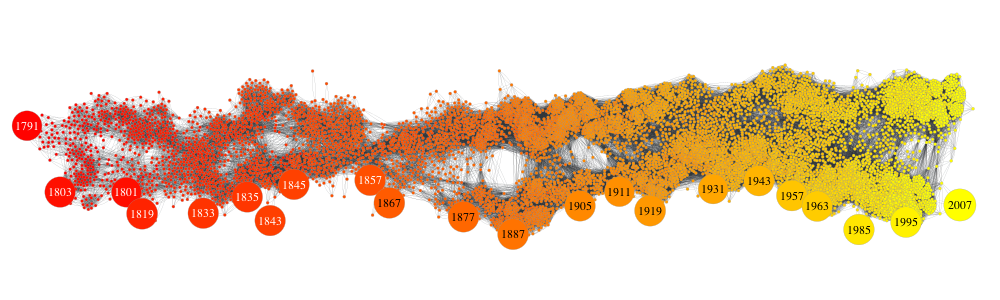

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13a058e10, at 0x13a058b38>

In [142]:
# Plot solutions for global eigenvector

c_map = plt.get_cmap('autumn')

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours, 
           vorder=node_order,
           vertex_text=node_text,
           edge_pen_width=0.1,
           vcmap=c_map, 
           output='senate.png')

# For exaplanation of the senate data please refer to
# K. Fountoulakis, D. Gleich and M. Mahoney, An optimization approach to locally-biased graph algorithms,
# Proceedings of the IEEE 105 (2), 256-272.

In [5]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


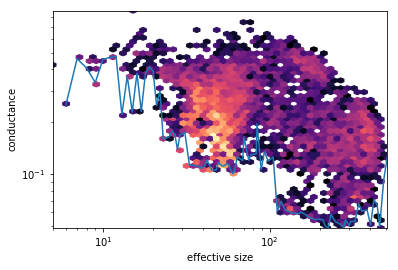

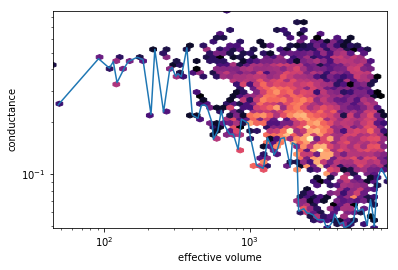

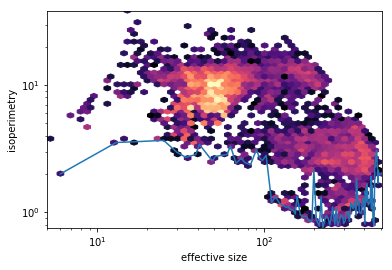

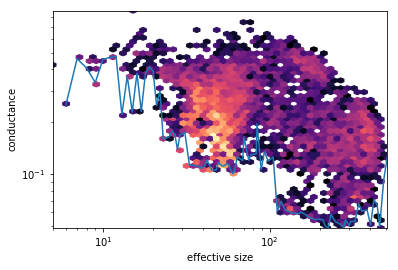

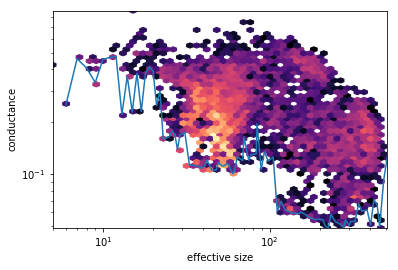

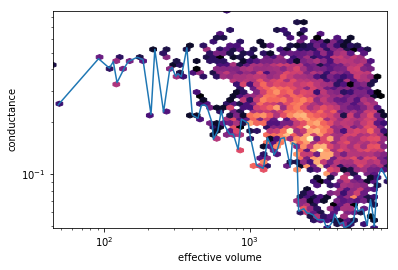

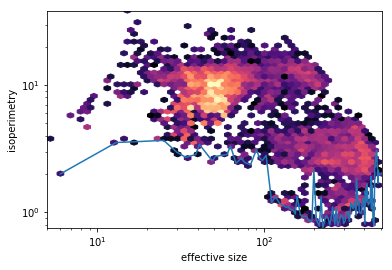

In [8]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [18]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/JohnsHopkins.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [19]:
## Add data to graphtool.
g_gtool = load_graph("./datasets/JohnsHopkins.graphml")
    
remove_self_loops(g_gtool)
g_v_prop = g_gtool.vertex_properties
feature_list = [g_v_prop.majorIndex,g_v_prop.year]

ref_nodes = []
    
for feature in feature_list:
    
    for ff in list(set(feature.a)):
    
        if ff != 2009 and ff != 217:
            continue

        feature_array = np.zeros(g_gtool.num_vertices())
        feature_ff_nodes = []
        for i in range(g_gtool.num_vertices()):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(g_gtool.num_vertices())) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        ref_nodes.append(feature_ff_nodes_largest_component)
    
print("Done!")

Done!


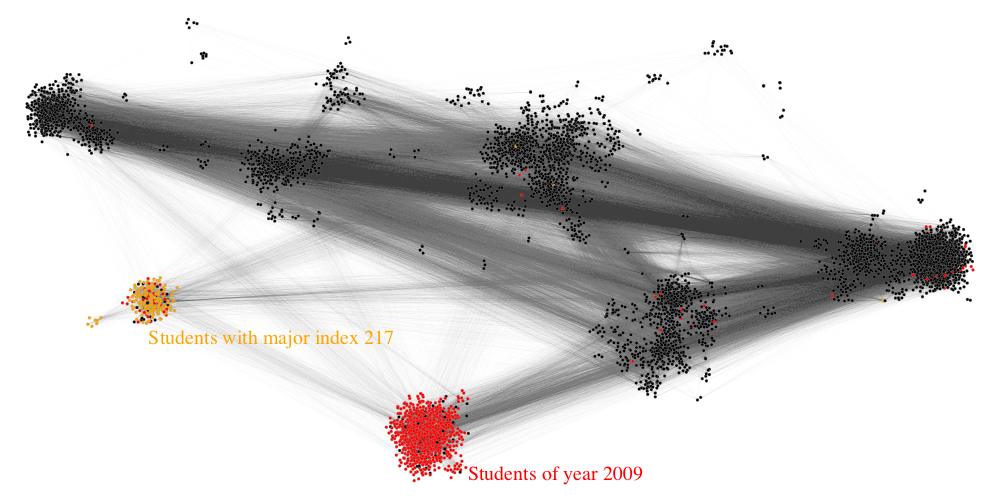

Number of labels: 24


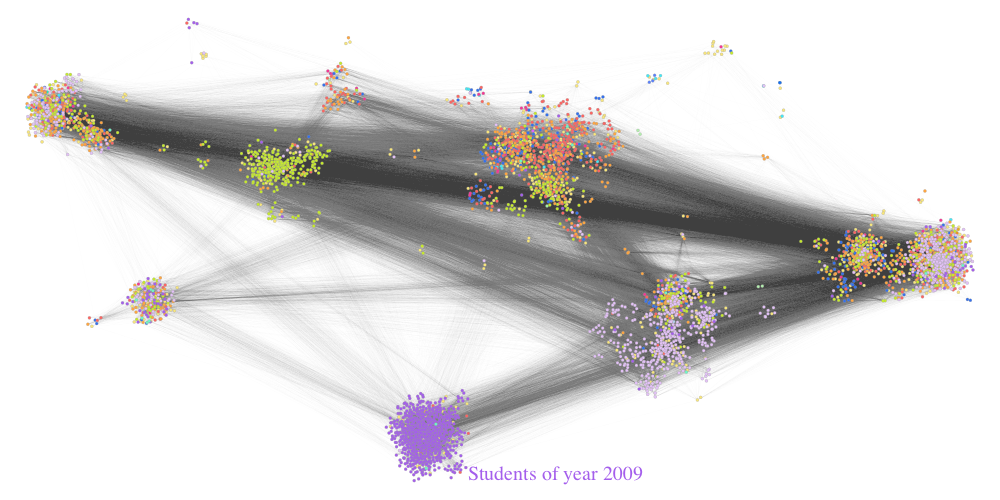

Number of labels: 93


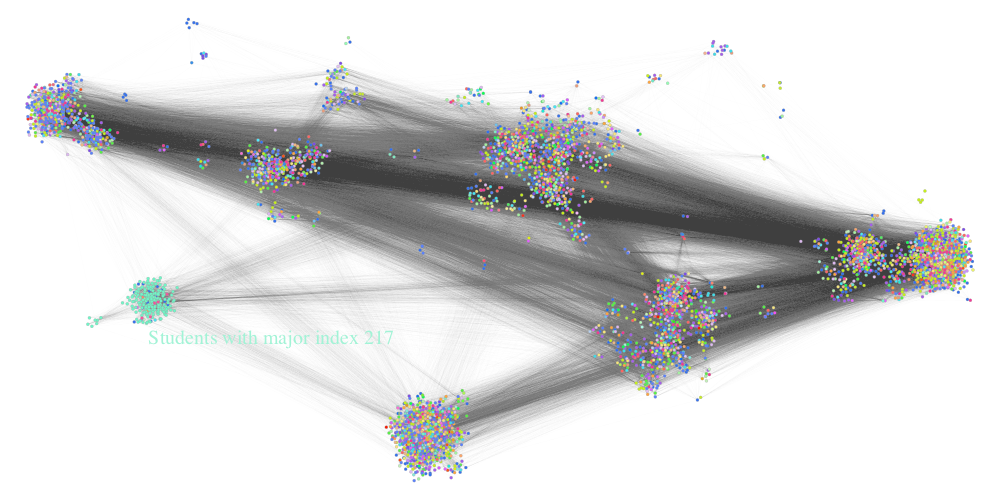

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14382c3c8, at 0x1484bf780>

In [20]:
# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/JohnHopkins_coord.xy', dtype = 'Float64')
idx = np.argsort(ld_coord[:,0])

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = ld_coord[idx[i],1:3]
    
temp = ["black" for x in range(g._num_vertices)]

for i in ref_nodes[0]:
    temp[i] = "orange"
for i in ref_nodes[1]:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

node_text = g_gtool.new_vertex_property("string")
node_order = g_gtool.new_vertex_property("int")
node_text_offset = g_gtool.new_vertex_property("vector<double>")
node_text_color = g_gtool.new_vertex_property("string")

for i in range(g._num_vertices):
    node_text_color[i] = "black"

node_text[4069] = "Students of year 2009"
node_order[4069] = 10
node_text_offset[4069] = [0,0]#[-0.5,23]
node_text_color[4069]="red"

node_text[1453] = "Students with major index 217"
node_order[1453] = 10
node_text_offset[1453] = [-0.5,15]
node_text_color[1453]="orange"

# Plot solutions for rounded eigenvector
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=1,
           vertex_font_size=20,
           vertex_text_offset=node_text_offset,
           vertex_text_color=node_text_color,
           output='JohnsHopkins_selected_features.png')

c_map_year = rand_cmap(len(set(g_v_prop.year.a)), type='bright', first_color_black=False, last_color_black=False, verbose=True)

feature_array = np.zeros(g_gtool.num_vertices(),dtype=int)
for i in range(g_gtool.num_vertices()):
    feature_array[i] = g_v_prop.year[i]

temp = np.zeros(g._num_vertices) + 3

node_size = g_gtool.new_vertex_property("double",temp)
node_colours = g_gtool.new_vertex_property("int",feature_array)
node_order = g_gtool.new_vertex_property("int",feature_array)
node_text = g_gtool.new_vertex_property("string")
#node_text_color = g_gtool.new_vertex_property("vector<double>")
node_text_offset = g_gtool.new_vertex_property("vector<double>")

node_text[4069] = "Students of year 2009"
#node_text_color[4069]=c_map_year(0)
node_text_offset[4069] = [0,0]#[-0.5,23]

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=1,
           vertex_font_size=20,
           vertex_text_color=c_map_year(1),
           vertex_text_offset=node_text_offset,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map_year,
           output='JohnsHopkins_year_feature.png')

c_map_majorindex = rand_cmap(len(set(g_v_prop.majorIndex.a)), type='bright', first_color_black=False, last_color_black=False, verbose=True)

feature_array = np.zeros(g_gtool.num_vertices(),dtype=int)
for i in range(g_gtool.num_vertices()):
    feature_array[i] = g_v_prop.majorIndex[i]

# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("int",feature_array)

temp = np.zeros(g._num_vertices) + 3

node_size = g_gtool.new_vertex_property("double",temp)
node_colours = g_gtool.new_vertex_property("int",feature_array)
node_order = g_gtool.new_vertex_property("int",feature_array)
node_text = g_gtool.new_vertex_property("string")
#node_text_color = g_gtool.new_vertex_property("vector<double>")

node_text[1453] = "Students with major index 217"
#node_text_color[1453]=c_map_majorindex(0)
node_text_offset[1453] = [-0.5,15]

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=1,
           vertex_font_size=20,
           vertex_text_color=c_map_majorindex(50),
           vertex_text_offset=node_text_offset,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map_majorindex,
           output='JohnsHopkins_majorIndex_feature.png')

<class 'localgraphclustering.ncp.NCPData'>


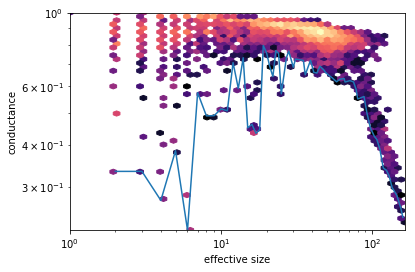

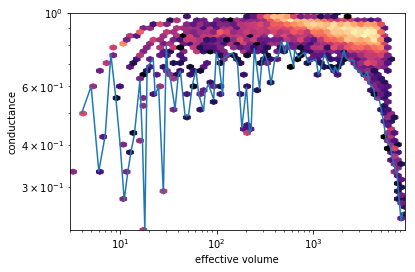

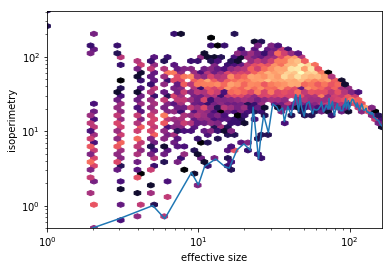

In [15]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [76]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/usroads-cc.graphml','graphml')

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/usroads-cc.xy', dtype = 'Float64')
ld_coord[:,0] = -ld_coord[:,0]

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


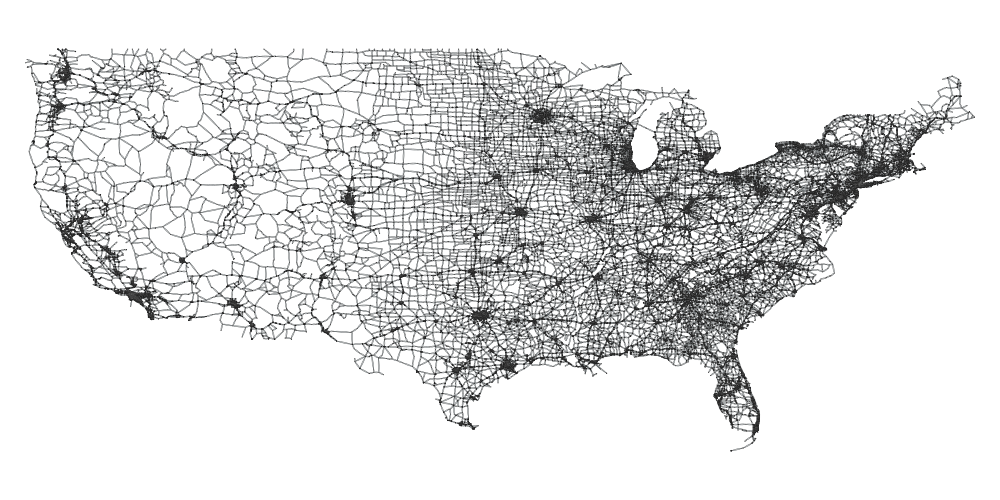

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1291e0358, at 0x10f2f2630>

In [77]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/usroads-cc.graphml")
    
remove_self_loops(g_gtool)

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = -ld_coord[i,:]

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=1,
           edge_pen_width=0.5,
           vertex_fill_color="black",
           output='usroad.png')

In [4]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


/usr/local/lib/python3.6/site-packages/localgraphclustering/spectral_clustering.py:92: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")
/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:106: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")


<class 'localgraphclustering.ncp.NCPData'>


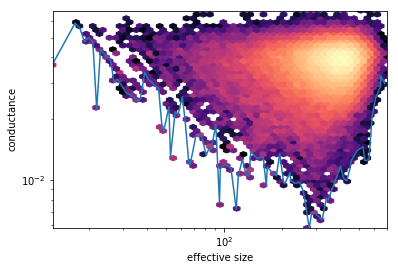

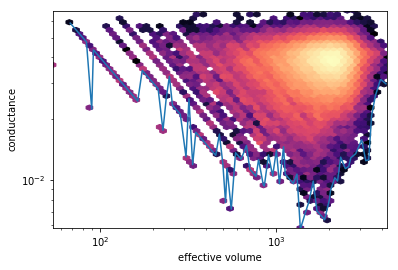

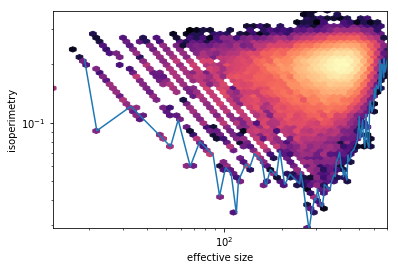

In [5]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [27]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/ca-GrQc-cc.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [28]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ca-GrQc-cc.graphml")
    
remove_self_loops(g_gtool)

# Compute a layout for the graph.
# pos = sfdp_layout(g_gtool, gamma=10.0, mu=10.0, mu_p=10.0, verbose = False)  

coordinates = pickle.load( open( "ca-GrQc-cc_xy.p", "rb" ) )

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g._num_vertices):
    pos[i] = coordinates[g_gtool.vertex(i)]

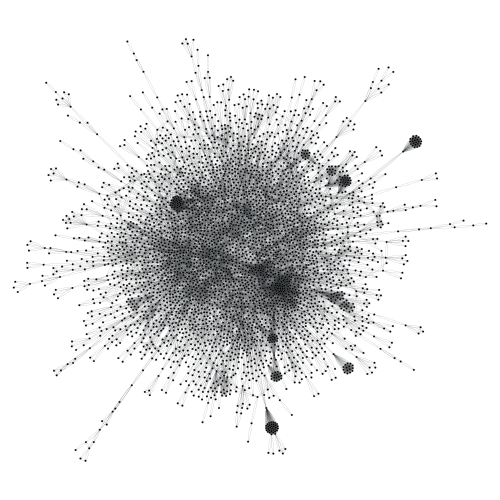

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1391264a8, at 0x13785dd68>

In [30]:
# Plot solutions for global eigenvector

graph_draw(g_gtool, pos, output_size=(500, 500),
           vertex_size=2,
           edge_pen_width=0.1,
           vertex_fill_color="black",
           output='ca-GrQc-cc.png')

In [20]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

There are  1  connected components in the graph


<class 'localgraphclustering.ncp.NCPData'>


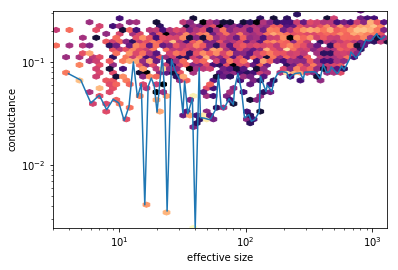

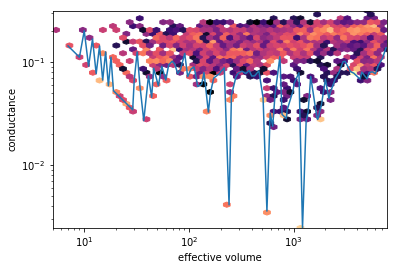

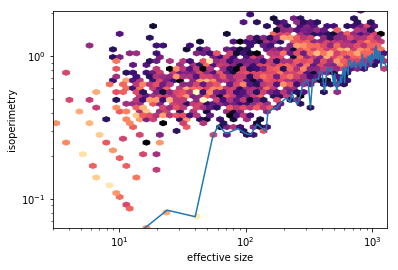

In [21]:
ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [21]:
# Read John Hopkins graph.
g = lgc.GraphLocal('./datasets/Colgate88_reduced.graphml','graphml')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [22]:
## Add data to graphtool.
g_gtool = load_graph("./datasets/Colgate88_reduced.graphml")
    
remove_self_loops(g_gtool)
g_v_prop = g_gtool.vertex_properties
feature_list = [g_v_prop.year]

ref_nodes = []
    
for feature in feature_list:
    
    for ff in list(set(feature.a)):
    
        if ff != 2006 and ff != 2007 and ff != 2008 and ff != 2009 :
            continue

        feature_array = np.zeros(g_gtool.num_vertices())
        feature_ff_nodes = []
        for i in range(g_gtool.num_vertices()):
            feature_array[i] = feature[i]
            if feature_array[i] == ff:
                feature_ff_nodes.append(i)

        g_ff = g_gtool.copy()

        del_list_ff = list(set(range(g_gtool.num_vertices())) - set(feature_ff_nodes))

        for v in reversed(sorted(del_list_ff)):
            g_ff.remove_vertex(v)   

        n_ff = g_ff.num_vertices() 

        comp_ff,hist_ff=label_components(g_ff)

        feature_ff_nodes_largest_component = []
        for i in range(n_ff):
            if comp_ff[i] == 0:
                feature_ff_nodes_largest_component.append(feature_ff_nodes[i])    

        ref_nodes.append(feature_ff_nodes_largest_component)
    
print("Done!")

Done!


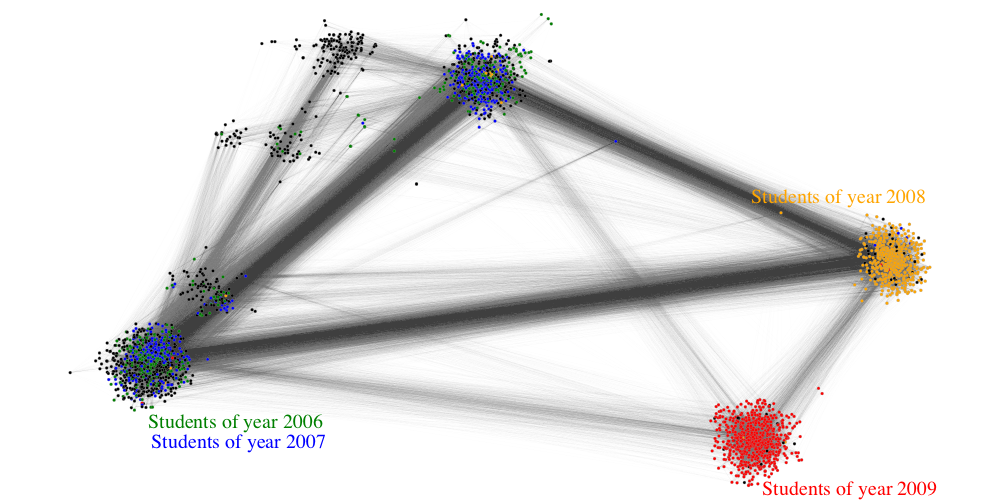

Number of labels: 14


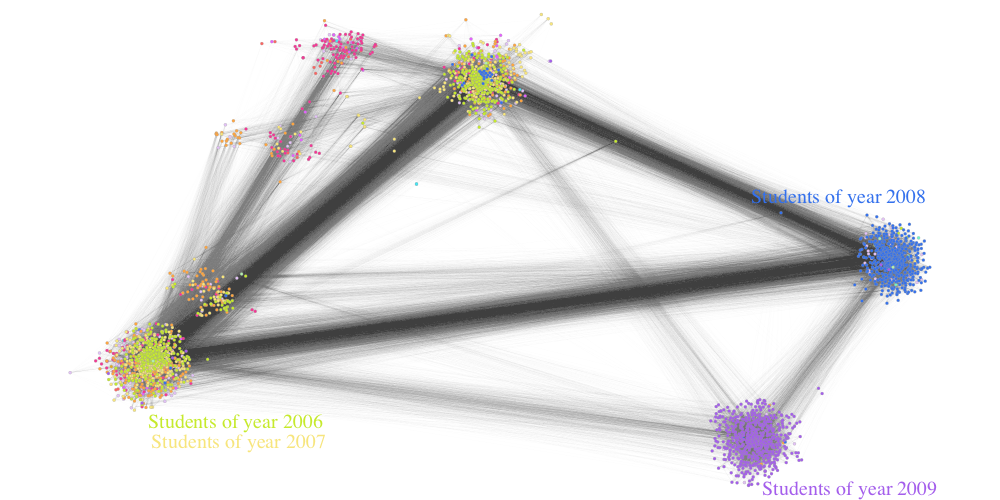

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14d28b7f0, at 0x1334a1a20>

In [23]:
# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = [xx[i],yy[i]]
    
temp = ["black" for x in range(g._num_vertices)]

for i in ref_nodes[0]:
    temp[i] = "green"
for i in ref_nodes[1]:
    temp[i] = "blue"
for i in ref_nodes[2]:
    temp[i] = "orange"
for i in ref_nodes[3]:
    temp[i] = "red"

node_colours = g_gtool.new_vertex_property("string",temp)

node_text = g_gtool.new_vertex_property("string")
node_order = g_gtool.new_vertex_property("int")
node_text_offset = g_gtool.new_vertex_property("vector<double>")
node_text_color = g_gtool.new_vertex_property("string")
node_text_position = g_gtool.new_vertex_property("int")

for i in range(g._num_vertices):
    node_text_color[i] = "black"

node_text[2651] = "Students of year 2008"
node_order[2651] = 10
node_text_offset[2651] = [-1,-30]
node_text_color[2651] = "orange"
node_text_position[2651] = 1.57

node_text[2115] = "Students of year 2009"
node_order[2115] = 10
node_text_offset[2115] = [2,13]
node_text_color[2115] = "red"
node_text_position[2115] = 1

node_text[2905] = "Students of year 2007"
node_order[2905] = 10
node_text_offset[2905] = [-0.5,23]
node_text_color[2905] = "blue"
node_text_position[2905] = 1

node_text[230] = "Students of year 2006"
node_order[230] = 10
node_text_offset[230] = [-0.5,15]
node_text_color[230] = "green"
node_text_position[230] = 1

# Plot solutions for rounded eigenvector
graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=3,
           vertex_fill_color=node_colours,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=node_text_position,
           vertex_font_size=20,
           vertex_text_offset=node_text_offset,
           vertex_text_color=node_text_color,
           output='colgate_selected_features.png')

c_map_year = rand_cmap(len(set(g_v_prop.year.a)), type='bright', first_color_black=False, last_color_black=False, verbose=True)

feature_array = np.zeros(g_gtool.num_vertices(),dtype=int)
for i in range(g_gtool.num_vertices()):
    feature_array[i] = g_v_prop.year[i]

temp = np.zeros(g._num_vertices) + 3

node_size = g_gtool.new_vertex_property("double",temp)
node_colours = g_gtool.new_vertex_property("int",feature_array)
node_order = g_gtool.new_vertex_property("int",feature_array)
node_text = g_gtool.new_vertex_property("string")
node_text_color = g_gtool.new_vertex_property("vector<double>")
node_text_offset = g_gtool.new_vertex_property("vector<double>")
node_text_position = g_gtool.new_vertex_property("int")

node_text[2651] = "Students of year 2008"
node_text_offset[2651] = [-1,-30]
node_text_color[2651] = c_map_year(5)
node_text_position[2651] = 1.57

node_text[2115] = "Students of year 2009"
node_text_offset[2115] = [2,13]
node_text_color[2115] = c_map_year(1)
node_text_position[2115] = 1

node_text[2905] = "Students of year 2007"
node_text_offset[2905] = [-0.5,23]
node_text_color[2905] = c_map_year(7)
node_text_position[2905] = 1

node_text[230] = "Students of year 2006"
node_text_offset[230] = [-0.5,15]
node_text_color[230] = c_map_year(2)
node_text_position[230] = 1

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_order,
           vertex_text=node_text,
           vertex_text_position=node_text_position,
           vertex_font_size=20,
           vertex_text_color=node_text_color,
           vertex_text_offset=node_text_offset,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map_year,
           output='colgate_year_feature.png')

There are  1  connected components in the graph
<class 'localgraphclustering.ncp.NCPData'>


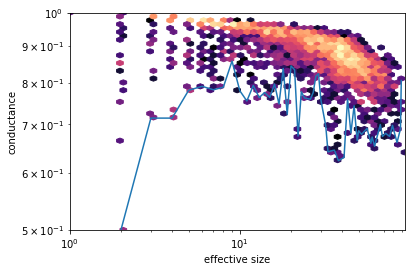

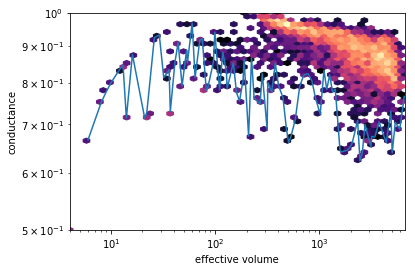

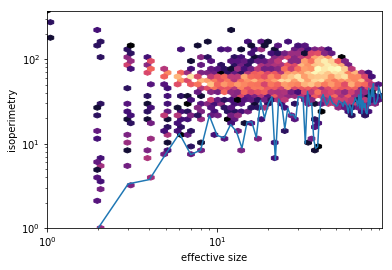

In [78]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [2]:
g = lgc.GraphLocal('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [ ]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ASTRAL-small-sized-mammoth-sims-geq-2.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

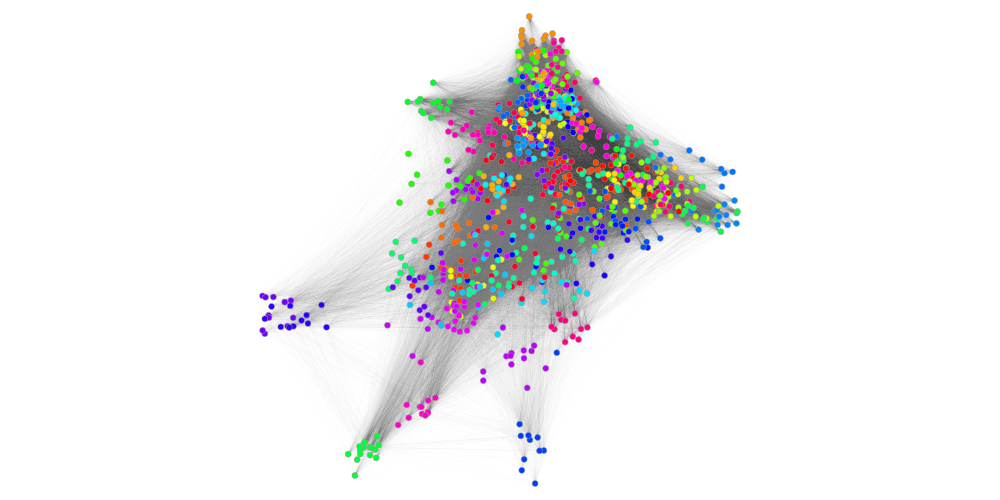

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x1471f8dd8, at 0x1464da7b8>

In [131]:
ld_coord = np.loadtxt('./datasets/ASTRAL-small-sized-mammoth-sims-geq-2_groundTruth.csv', dtype = 'str')

cluster_type = []
for i in ld_coord:
    cluster_type.append(i[1])
cluster_type_set = set(cluster_type)

idxs_cluster_type = dict(zip(cluster_type_set, range(len(cluster_type_set)))) 

protein_color = np.zeros(len(cluster_type))
for i in range(len(cluster_type)):
    protein_color[idxs[ld_coord[i][0]]] = idxs_cluster_type[ld_coord[i][1]]
    
# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("double",protein_color)

temp = np.zeros(g._num_vertices) + 6

node_size = g_gtool.new_vertex_property("double",temp)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

c_map = get_cmap(g_gtool.num_vertices())

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map,
           output='astral.png')

There are  1  connected components in the graph


/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:106: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")
/usr/local/lib/python3.6/site-packages/localgraphclustering/spectral_clustering.py:92: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")


<class 'localgraphclustering.ncp.NCPData'>


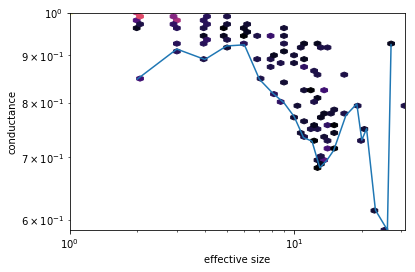

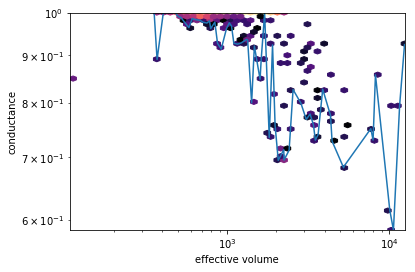

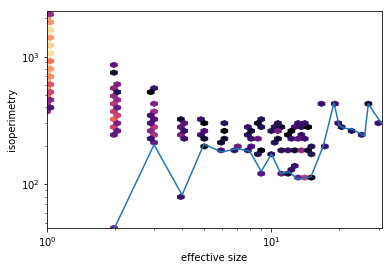

In [10]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [5]:
# Read graph. This also supports gml and graphml format.
# The MIPS Mammalian Protein-Protein Database is a database for protein-protein interactions of mammalian species. 
# We used the data set proposed in consisting of a subset of 220 protein complexes of 1562 proteins. 
# Details can be found here: https://clusteval.sdu.dk/1/datasets/685
g = lgc.GraphLocal('./datasets/ppi_mips.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [133]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ppi_mips.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/ppi_mips_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

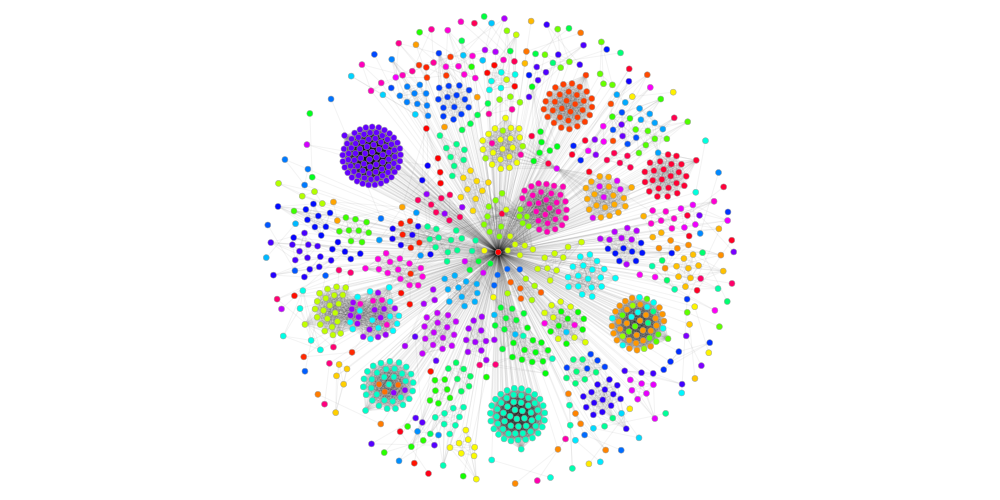

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x14849b710, at 0x14849bc50>

In [134]:
ld_coord = np.loadtxt('./datasets/ppi_mips_ground_truth.csv', dtype = 'str')

cluster_type = []
for i in ld_coord:
    cluster_type.append(i[1])
cluster_type_set = set(cluster_type)

idxs_cluster_type = dict(zip(cluster_type_set, range(len(cluster_type_set)))) 

protein_color = np.zeros(len(cluster_type))
for i in range(len(cluster_type)):
    protein_color[idxs[ld_coord[i][0]]] = idxs_cluster_type[ld_coord[i][1]]
    
# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("double",protein_color)

temp = np.zeros(g._num_vertices) + 6

node_size = g_gtool.new_vertex_property("double",temp)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

c_map = get_cmap(g_gtool.num_vertices())

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map,
           output='ppi_mips.png')

There are  1  connected components in the graph


/usr/local/lib/python3.6/site-packages/localgraphclustering/spectral_clustering.py:92: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")
/usr/local/lib/python3.6/site-packages/localgraphclustering/approximate_PageRank.py:106: UserWarning: The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.
  warnings.warn("The weights of the graph will be discarded. Use approximate_PageRank_weighted instead if you want to keep the edge weights.")


<class 'localgraphclustering.ncp.NCPData'>


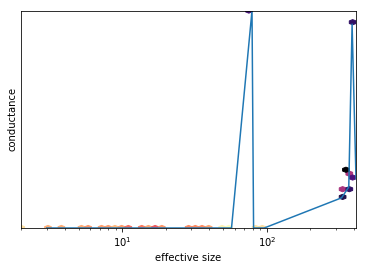

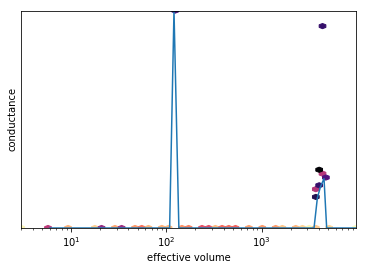

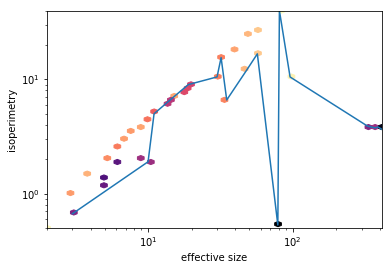

In [15]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [11]:
# Read graph. This also supports gml and graphml format.
# The data set contains pairwise similarities of blasted 
# sequences of 232 proteins belonging to the amidohydrolase superfamily. 
g = lgc.GraphLocal('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [136]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_coordinates.xy', dtype = 'str')

temp = []
for i in ld_coord:
    temp.append(i[0])

idxs = dict(zip(temp, range(len(temp)))) 

pos = g_gtool.new_vertex_property("vector<double>")
for i in ld_coord:
    pos[idxs[i[0]]] = i[1:3]

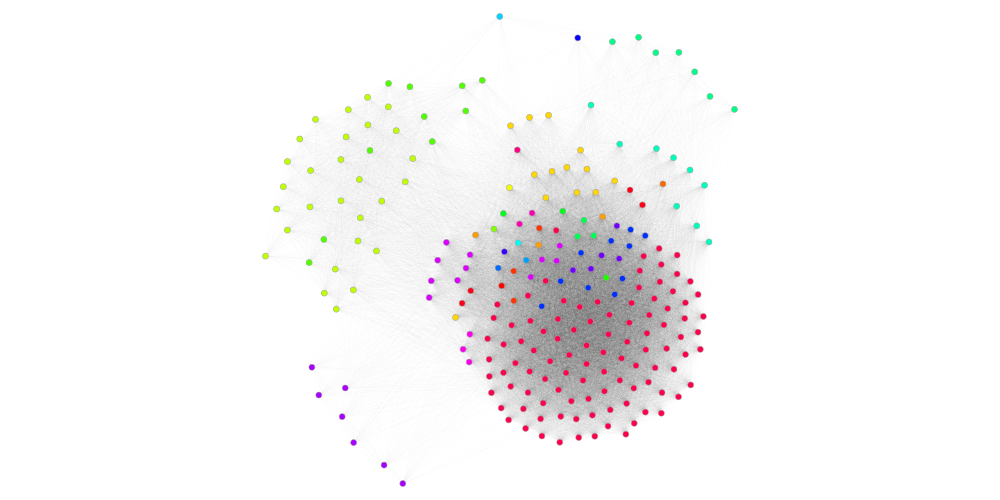

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x133996be0, at 0x11144f978>

In [137]:
ld_coord = np.loadtxt('./datasets/sfld_brown_et_al_amidohydrolases_protein_similarities_for_beh_ground_truth.csv', dtype = 'str')

cluster_type = []
for i in ld_coord:
    cluster_type.append(i[1])
cluster_type_set = set(cluster_type)

idxs_cluster_type = dict(zip(cluster_type_set, range(len(cluster_type_set)))) 

protein_color = np.zeros(len(cluster_type))
for i in range(len(cluster_type)):
    protein_color[idxs[ld_coord[i][0]]] = idxs_cluster_type[ld_coord[i][1]]
    
# Plot solutions for rounded eigenvector
node_colours = g_gtool.new_vertex_property("double",protein_color)

temp = np.zeros(g._num_vertices) + 6

node_size = g_gtool.new_vertex_property("double",temp)

def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

c_map = get_cmap(g_gtool.num_vertices())

graph_draw(g_gtool, pos, output_size=(1000, 500),
           vertex_size=node_size, 
           vertex_fill_color=node_colours, 
           vorder=node_size,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.05],
           vcmap = c_map,
           output='sfld.png')

There are  1  connected components in the graph
<class 'localgraphclustering.ncp.NCPData'>


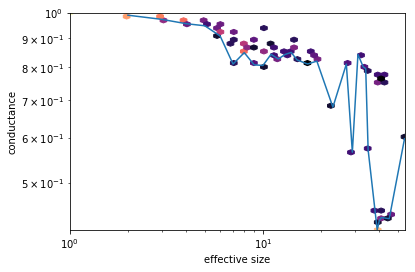

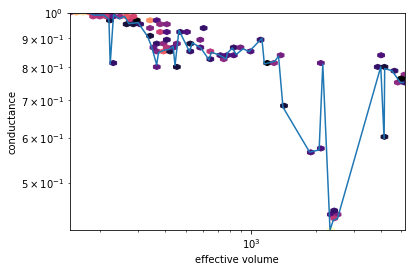

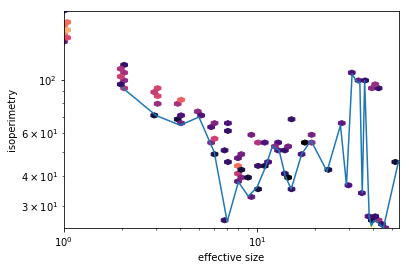

In [20]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [18]:
g = lgc.GraphLocal('./datasets/Erdos02-cc.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [19]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/Erdos02-cc.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = [xx[i],yy[i]]

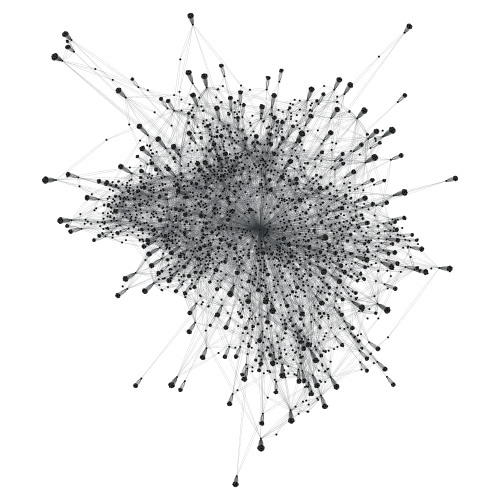

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x136ed4b00, at 0x136ed4c18>

In [20]:
# Plot solutions for global eigenvector

graph_draw(g_gtool, pos, output_size=(500, 500),
           vertex_size=2,
           edge_pen_width=0.1,
           vertex_fill_color="black",
           output='Erdos.png')

There are  1  connected components in the graph
<class 'localgraphclustering.ncp.NCPData'>


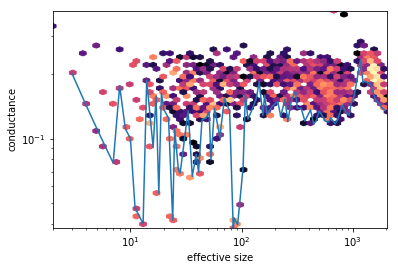

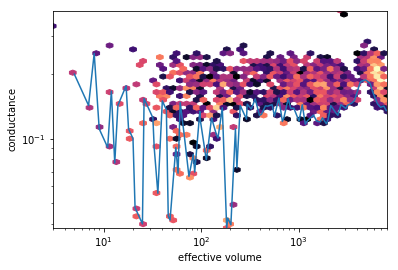

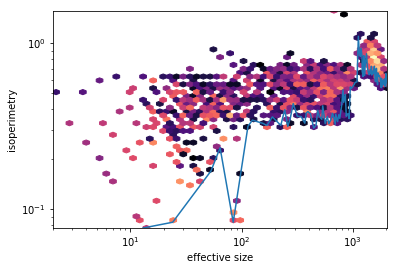

In [24]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [21]:
g = lgc.GraphLocal('./datasets/neuro-fmri-01.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [22]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/neuro-fmri-01.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = [xx[i],yy[i]]

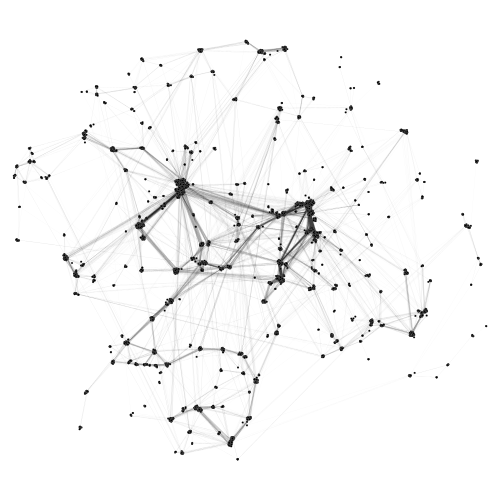

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x139126ef0, at 0x1391260f0>

In [23]:
# Plot solutions for global eigenvector

graph_draw(g_gtool, pos, output_size=(500, 500),
           vertex_size=2,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.08],
           vertex_fill_color="black",
           output='neuro.png')

There are  1  connected components in the graph
<class 'localgraphclustering.ncp.NCPData'>


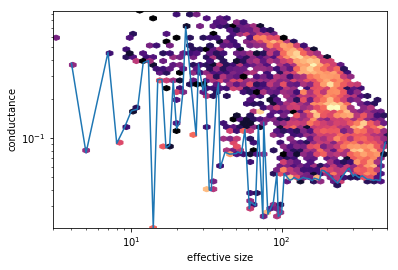

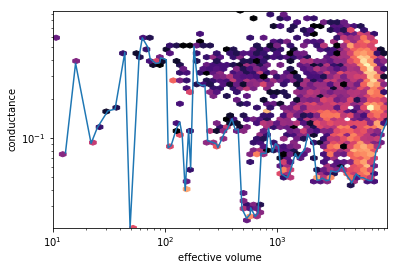

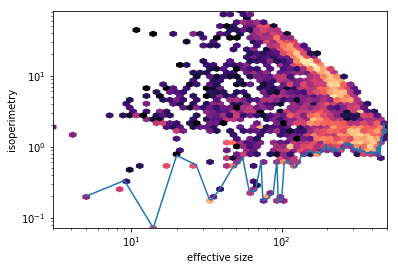

In [28]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()

In [24]:
g = lgc.GraphLocal('./datasets/ppi-homo.graphml','graphml',' ')

/usr/local/lib/python3.6/site-packages/localgraphclustering/GraphLocal.py:174: UserWarning: Loading a graphml is not efficient, we suggest using an edgelist format for this API.
  warnings.warn("Loading a graphml is not efficient, we suggest using an edgelist format for this API.")


In [25]:
# Add data to graphtool.
g_gtool = load_graph("./datasets/ppi-homo.graphml")
    
remove_self_loops(g_gtool)

# Load pre-computed coordinates for nodes.
g_v_prop = g_gtool.vertex_properties
xx = g_v_prop.x
yy = g_v_prop.y

pos = g_gtool.new_vertex_property("vector<double>")
for i in range(g_gtool.num_vertices()):
    pos[i] = [xx[i],yy[i]]

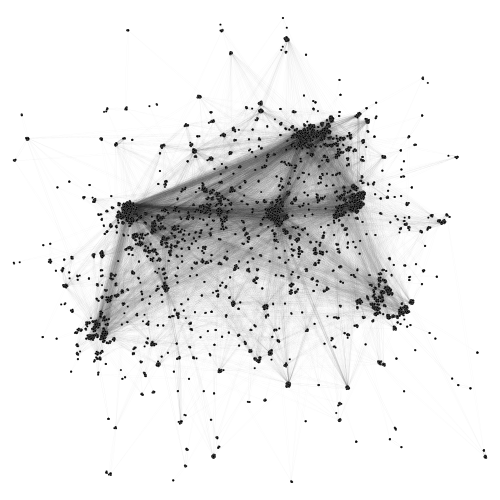

<PropertyMap object with key type 'Vertex' and value type 'vector<double>', for Graph 0x13b9f6c50, at 0x13b9f66a0>

In [26]:
# Plot solutions for global eigenvector

graph_draw(g_gtool, pos, output_size=(500, 500),
           vertex_size=2,
           edge_pen_width=0.1,
           edge_color = [0.0, 0, 0, 0.08],
           vertex_fill_color="black",
           output='ppi-homo.png')

There are  1  connected components in the graph
<class 'localgraphclustering.ncp.NCPData'>


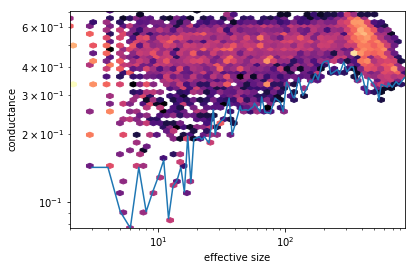

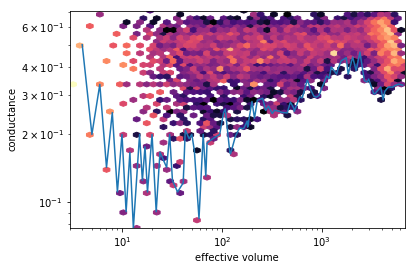

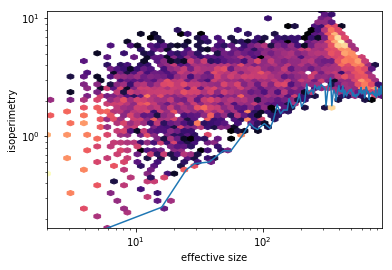

In [67]:
ncp_instance = lgc.NCPData(g)
ncp_instance.approxPageRank(ratio=0.5,timeout=7200)

ncp_plots = lgc.NCPPlots(ncp_instance,method_name = "acl")
#plot conductance vs size
fig, ax = ncp_plots.cond_by_size()
plt.show()
#plot conductance vs volume
fig, ax = ncp_plots.cond_by_vol()
plt.show()
#plot isoperimetry vs size
fig, ax = ncp_plots.isop_by_size()
plt.show()